# 2022-03-14 Regression

## Last time

* Noisy data
* Bias-variance tradeoff
* Experiments with [class notebook](https://github.com/cu-numcomp/spring22/blob/main/slides/2022-03-11-noisy-data.ipynb)

## Today

* Discussion
* Bias-variance tradeoff
* Linear models
* Loss functions and partial derivatives

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

runge(x) = 1 / (1 + 10*x^2)

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

# Bias-variance tradeoff

The expected error in our approximation $\hat f(x)$ of noisy data $y = f(x) + \epsilon$ (with $\epsilon \sim \mathcal N(0, \sigma)$), can be decomposed as
$$ E[(\hat f(x) - y)^2] = \sigma^2 + \big(\underbrace{E[\hat f(x)] - f(x)}_{\text{Bias}}\big)^2 + \underbrace{E[\hat f(x)^2] - E[\hat f(x)]^2}_{\text{Variance}} . $$
The $\sigma^2$ term is irreducible error (purely due to observation noise), but bias and variance can be controlled by model selection.
More complex models are more capable of expressing the underlying function $f(x)$, thus are capable of reducing bias.  However, they are also more affected by noise, thereby increasing variance.

# Regression using polynomials

In [70]:
function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    vander_chebyshev(xx, n) / V
end

runge(x) = 1 / (1 + 10*x^2)
runge_noisy(x, sigma) = runge.(x) + randn(size(x)) * sigma

x = LinRange(-1, 1, 500)
ytrain = runge_noisy(x, 0.5)
yfit = chebyshev_regress_eval(x, x, 7) * ytrain
size(ytrain), size(yfit)

((500,), (500,))

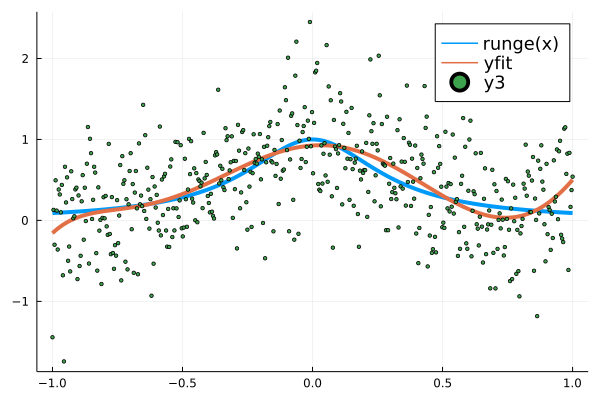

In [71]:
plot(x, runge.(x), label="runge(x)")
plot!(x, yfit, label="yfit")
scatter!(x, ytrain, markersize=2)

In [72]:
ytest = runge_noisy(x, 0.5)
@show norm(yfit - ytrain)
@show norm(yfit - ytest);

norm(yfit - ytrain) = 11.237591955727229
norm(yfit - ytest) = 11.828336823547042


# What happens as we increase polynomial degree?

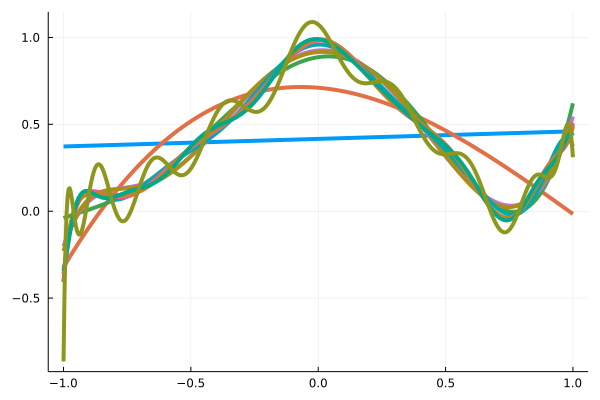

In [73]:
ks = 2:2:20
p = plot(legend=:none)
function residuals(k)
    # Fit polynomial of degree k to ytrain.
    yfit = chebyshev_regress_eval(x, x, k) * ytrain
    plot!(x, yfit, label="k=$k")
    [norm(yfit - ytrain) norm(yfit - ytest)]
end

res = vcat([residuals(k) for k in ks]...)
p

size(res) = (10, 2)


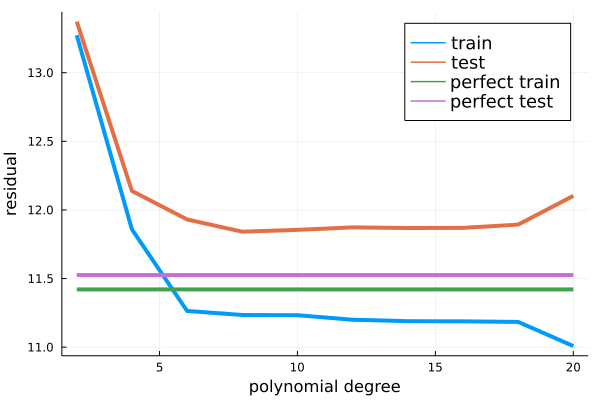

In [74]:
@show size(res)

plot(ks, res[:,1], label="train", xlabel="polynomial degree", ylabel="residual")
plot!(ks, res[:,2], label="test")
plot!(ks, _ -> norm(runge.(x)-ytrain), label="perfect train")
plot!(ks, _ -> norm(runge.(x)-ytest), label="perfect test")

# Interpretation questions
Think about these questions, re-run the notebook, and try to formulate an answer.
Please discuss online (Zulip or with a friend).

* Is "perfect train" (residual for the noisy sample of the zero-noise function) always greater than (or less than) "perfect test"?
* Can you identify when we begin "overfitting" by comparing "train" with "perfect train"?  Does it happen at about the same degree each time?
* In the real world, we don't have access to the zero-noise function, thus can't mark "perfect train".  By looking at just "train" and "test", can you identify (roughly) when we begin overfitting?

# Bias and variance over multiple training sets

What have we just done?

* We took one noisy sample of a function
* Fit polynomials of increasing degree to it
* Computed the residual of that fit on
  * the training data
  * an independent "test" sample
  
## What happens if we repeat this process?
* Scroll up and re-run above
* We'll do it many times below

# Stacking many realizations

size(Y) = (500, 50)


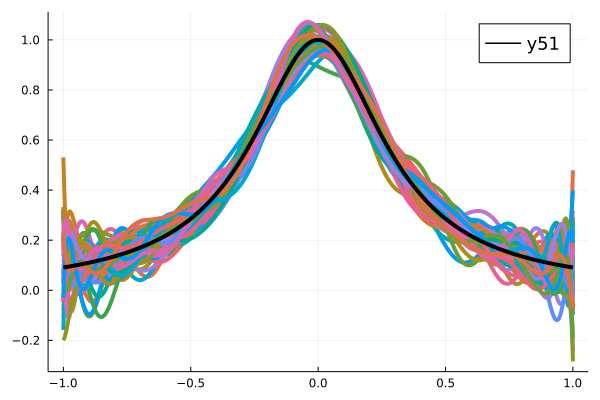

In [80]:
degree = 20
Y = []
for i in 1:50
    yi = runge_noisy(x, 0.25)
    push!(Y, chebyshev_regress_eval(x, x, degree) * yi)
end

Y = hcat(Y...)
@show size(Y) # (number of points in each fit, number of fits)
plot(x, Y, label=nothing);
plot!(x, runge.(x), color=:black)

# Interpretation

* Re-run the cell above for different values of `degree`.  (Set it back to a number around 7 to 10 before moving on.)
* Low-degree polynomials are not rich enough to capture the peak of the function.
* As we increase degree, we are able to resolve the peak better, but see more eratic behavior near the ends of the interval.  This erratic behavior is **overfitting**, which we'll quantify as *variance*.
* This tradeoff is fundamental: richer function spaces are more capable of approximating the functions we want, but they are more easily distracted by noise.

# Mean over all the realizations

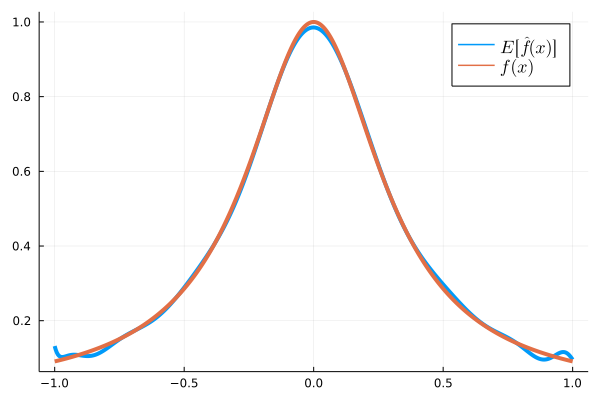

In [81]:
Ymean = sum(Y, dims=2) / size(Y, 2)
plot(x, Ymean, label="\$ E[\\hat{f}(x)] \$")
plot!(x, runge.(x), label="\$ f(x) \$")

# Variance over the realizations

size(Yvar) = (500, 1)


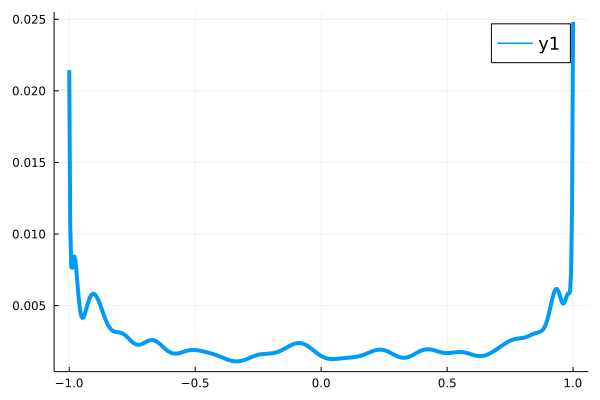

In [83]:
function variance(Y)
    """Compute the Variance as defined at the top of this activity"""
    ## BEGIN SOLUTION
    n = size(Y, 2)
    sum(Y.^2, dims=2)/n - (sum(Y, dims=2) / n) .^2
    ## END SOLUTION
end

Yvar = variance(Y)
@show size(Yvar)
plot(x, Yvar)

In [11]:
@assert size(variance(Y)) == (size(Y, 1), 1)

# Another take on the Runge phenomenon

The fact that variance blows up toward the end of our interval is a property of the approximation space (polynomials).
Recall that it doesn't depend on the basis used for fitting (Chebyshev in this case); that choice only relates to stability.
If we could choose an approximation space such that variance was flat across the interval $[-1, 1]$, we would be able to solve interpolation problems on equally spaced grids without numerical artifacts like the Runge phenomenon.
Finding spaces of functions have flat variance and are rich enough to approximate interesting functions is "hard" (math speak for has no general solution).
It is possible in special circumstances, such as for periodic functions, in which the Fourier basis (sine and cosine functions) can be used.

In practice, we often use **regularization** to modify the least squares objective such that we can reduce variance while using function spaces rich enough to keep bias low.